# Import libraries

In [23]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from sklearn import datasets
import numpy as np


# Load dataset

In [2]:
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [3]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

# Prepare data

In [4]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

### Add the bias term for every instance

In [7]:
X_with_bias = np.c_[np.ones([len(X), 1]), X]

In [ ]:
np.random.seed(2042)

# Split the dataset

In [8]:
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)

test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size

rnd_indices = np.random.permutation(total_size)

X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]
X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]
X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]

### Add one-hot vector

In [9]:
def to_one_hot(y):
    n_classes = y.max() + 1
    m = len(y)
    Y_one_hot = np.zeros((m, n_classes))
    Y_one_hot[np.arange(m), y] = 1
    return Y_one_hot

### Test the one-hot function

In [10]:
y_train[:10]

array([0, 1, 1, 0, 2, 1, 2, 0, 1, 2])

In [11]:
to_one_hot(y_train[:10])

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

# Create target class probabilities matrix for training set and test set

In [12]:
Y_train_one_hot = to_one_hot(y_train)
Y_valid_one_hot = to_one_hot(y_valid)
Y_test_one_hot = to_one_hot(y_test)

### Softmax function

In [13]:
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = np.sum(exps, axis=1, keepdims=True)
    return exps / exp_sums

# Train the model

In [14]:
n_inputs = X_train.shape[1] # == 3 (2 features plus the bias term)
n_outputs = len(np.unique(y_train))   # == 3 (3 iris classes)

In [15]:
eta = 0.01
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    if iteration % 500 == 0:
        loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
        print(iteration, loss)
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error)
    Theta = Theta - eta * gradients

0 2.698914429940692
500 1.0290580000652474
1000 0.7972748274128466
1500 0.6625843909673923
2000 0.5814817333217215
2500 0.5282490988954471
3000 0.49033666918476404
3500 0.46154580387700145
4000 0.43860344231842535
4500 0.41965100222822876
5000 0.40356153606607975


In [16]:
Theta

array([[ 3.13573756, -0.0270357 , -2.24853211],
       [-1.56436747, -0.98002544, -1.0626491 ],
       [-1.545171  ,  0.59731436,  2.4095438 ]])

# Evaluate the model

In [17]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0.9

### Add Regularization L2 to improve the model results

In [18]:
eta = 0.1
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # regularization hyperparameter

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    if iteration % 500 == 0:
        xentropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
        l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
        loss = xentropy_loss + alpha * l2_loss
        print(iteration, loss)
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

0 2.9688388754913797
500 0.5319953988222683
1000 0.5007464071576339
1500 0.4914197072217739
2000 0.48784973564612555
2500 0.48635818055874747
3000 0.48570708968670956
3500 0.4854156563954183
4000 0.48528318844107954
4500 0.48522238410797497
5000 0.4851942952622425


### Evaluate the new model

In [19]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0.9666666666666667

### Add early stopping to model

In [20]:
eta = 0.1 
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # regularization hyperparameter
best_loss = np.infty

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

    logits = X_valid.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_valid_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    if iteration % 500 == 0:
        print(iteration, loss)
    if loss < best_loss:
        best_loss = loss
    else:
        print(iteration - 1, best_loss)
        print(iteration, loss, "early stopping!")
        break

0 3.8815688388072336
500 0.5449284806749135
1000 0.5171614296736261
1500 0.5079264161613687
2000 0.5041671109702233
2500 0.5025201094401124
3000 0.5017630416213343
3500 0.5014011420133394
4000 0.5012217088268259
4500 0.5011294010854442
5000 0.5010800598747334


### Evalute metrics in model with early stopping callback

In [21]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0.9666666666666667

# Plot the model results

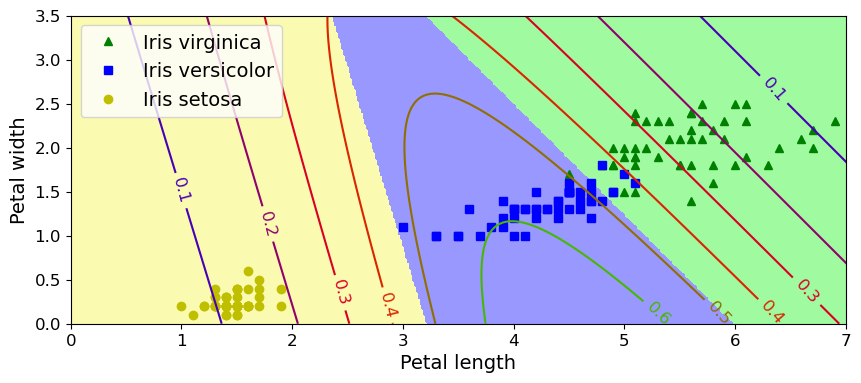

In [24]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new_with_bias = np.c_[np.ones([len(X_new), 1]), X_new]

logits = X_new_with_bias.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

In [25]:
logits = X_test.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_test)
accuracy_score

0.9